## Instructions

1. Do not write your name on the assignment. Be careful about any warnings that might display some file path with your name included.

2. You may talk to a friend, discuss the questions and potential directions for solving them. However, you need to write your own solutions and code separately, and not as a group activity.

3. You are expected to carefully read and comply with the [generative AI policy](https://canvas.northwestern.edu/courses/233157/pages/generative-ai-policy?module_item_id=3421526) of this course.

4. Write your code in the *Code* cells and print the instructed output. If you are instructed to explain something in words, write your answer in the *Markdown* cells of the Jupyter notebook. Ensure that the solution is coded and/or written neatly enough to understand and grade.

5. Use [Quarto](https://quarto.org/docs/output-formats/html-basics.html) to render the *.ipynb* file as HTML. You will need to open the command prompt, navigate to the directory containing the file, and use the command: `quarto render filename.ipynb --to html`. Submit the HTML file.

6. This assignment is worth 100 points and is due on **May 15, 2025 at 11:59 pm**. 

7. **Five points given for properly formatting the assignment**. The breakdown is as follows:
- The submission must be an HTML file rendered using Quarto. (1 point).
- Your name should not be visible in the HTML file (including the file path in any warning that your code returns). (1 point)
- There are not excessively long outputs of extraneous information. (e.g. no printouts of entire data frames without good reason; there are not long printouts of which iteration a loop is on; there are not long sections of commented-out code, etc.) (1 point)
- Final answers for each question are written in Markdown cells. (1 point).
- There is no piece of unnecessary / redundant code, and no unnecessary / redundant text. (1 point)

In [125]:
import warnings
warnings.filterwarnings("ignore")

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold


## 1) Regression with Bagging (53 points)

In this question, you will use the **miami_housing.csv** file. You can find the description for the variables [here](https://www.kaggle.com/datasets/deepcontractor/miami-housing-dataset).

The `SALE_PRC` variable is the regression response and the rest of the variables, except `PARCELNO`, are the predictors.

### a)

Read the dataset. **(1 point)**

In [127]:
miami_data = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-3/Datasets/miami-housing.csv")

### b)

Create the training and test datasets with a 60%-40% split and `random_state = 1`. **(1 point)**

In [128]:
predictors = miami_data.drop(columns=["SALE_PRC", "PARCELNO"], axis=1)
response = miami_data["SALE_PRC"]

X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.4, random_state=1)

### c) 

Explain why scaling is not a necessary preprocessing step in this assignment, which is entirely about tree-based models. **(3 points)**

Tree-based models make decisions based on whether or not a feature exceeds a certain threshold (determined at each node) and these thresholds are specific to each feature. Thus, we don't have to scale features to all be comparable since features are only compared to each other. 

### d)

Train a decision tree regressor with `random_state = 1` and all the hyperparameters as **their default values.** Return the training and test Mean Absolute Error (MAE). How do they compare? Why is this the case? **(2 points)**

In [129]:
decision_tree_regressor = DecisionTreeRegressor(random_state=1)
decision_tree_regressor.fit(X_train, y_train)
y_pred_dec_tree_reg = decision_tree_regressor.predict(X_test)

train_mae = mean_absolute_error(y_train, decision_tree_regressor.predict(X_train))
test_mae = mean_absolute_error(y_test, y_pred_dec_tree_reg)

print("Train MAE", train_mae)
print("Test MAE", test_mae)

Train MAE 16.517127248075926
Test MAE 67267.55768885699


Test MAE is much higher than test MAE, likely because the model is overfitting significantly. The train MAE is also really low, likely because the model is memorizing noise in the training data.

### e)

Tune a decision tree regressor to get below a **5-fold** cross-validation MAE of $68,000. The requirements are:

-  Keep the `random_state` of **any object that takes a `random_state` input** as 1.
-  Use the decision tree hyperparameters used in the lectures for consistency.
-  Do not use any loops while tuning the decision tree.
-  In your final submission, include an actual grid that is run with **at least 500** different hyperparameter combinations. 

Any solution that fails to meet these requirements will not receive any credit. Note that any other aspects are entirely up to you, including the grid values, how to approach any coarse and/or fine grids, and the cross-validation settings (except the number of folds given above).

**(10 points)**

In [130]:
from sklearn.model_selection import RepeatedKFold

model_part_e = DecisionTreeRegressor(random_state=1)

grid = {
    "max_depth": range(2, 30, 3),
    "max_leaf_nodes": range(2, 5000, 100)
}

cv = KFold(n_splits=5, shuffle=True, random_state=1)

gscv = GridSearchCV(
    estimator=model_part_e,
    param_grid=grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gscv.fit(X_train, y_train)
print("Best parameters: ", gscv.best_params_)
print("Best score: ", -gscv.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters:  {'max_depth': 23, 'max_leaf_nodes': 1102}
Best score:  67697.0454051744


### f)

Find the test MAE of the tuned decision tree in Part e to see if it generalizes well. **(1 point)** 

In [131]:
gscv_model = gscv.best_estimator_
y_pred_gscv = gscv_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred_gscv)
print(test_mae)

64197.151174750004


### g)

Create and train a bagged trees regressor. Keep all the hyperparameters (both in the base and in the bagging model) as default, except for `n_estimators`. For `n_estimators`, **efficiently** find a number which stabilizes the performance of the bagged trees model. Return the test MAE. You need to see **a test MAE below $50,000 for credit**.

The requirements are:

-  Keep the `random_state` of **any object that takes a `random_state` input** as 1.
-  Implement the method that is specific to bagging models to find a good `n_estimators` efficiently. Note that you are expected to know this method from the lectures. Cross-validation is not efficient and trial and error is not accepted.

Any solution that fails to meet these requirements will not receive any credit.

**(5 points)**

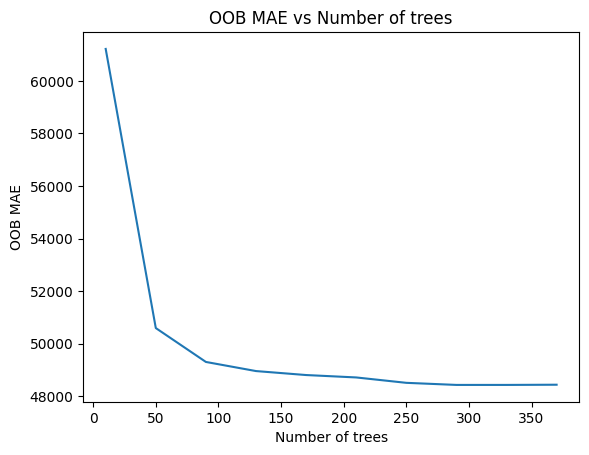

In [132]:
oob_mae = []

num_trees = np.arange(10,400,40)

for num_tree in num_trees:
    base_model = DecisionTreeRegressor(random_state=1)
    model = BaggingRegressor(
        estimator=base_model,
        n_estimators=num_tree,
        random_state=1,
        oob_score=True)
    model.fit(X_train, y_train)
    oob_predictions = model.oob_prediction_
    oob_mae.append(mean_absolute_error(y_train, oob_predictions))
    
plt.plot(num_trees, oob_mae)
plt.xlabel("Number of trees")
plt.ylabel("OOB MAE")
plt.title("OOB MAE vs Number of trees")
plt.show()

In [133]:
# MAE seems to stabilize around 250 trees will use that
base_model = DecisionTreeRegressor(random_state=1)
model = BaggingRegressor(
    estimator=base_model,
    n_estimators=250,
    random_state=1,
    oob_score=True
)
model.fit(X_train, y_train)
y_pred_bag = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_bag)
print(test_mae)

46253.529737629564


### h)

Explain why the bagged trees model with default values and a large number of trees (in Part g) is performing better than a single decision tree with default or with tuned values. **(2 points)**

The bagged trees model with default values outperforms even tuned single decision tree models because bagging averages the predictions of, in my case 200, a large number of overfitting trees, thereby reducing variance. In contrast, a single decision tree could very likely overfit by memorizing noise.

### i)

Tune a bagged trees regressor to get below a **5-fold** cross-validation MAE of $48,000. The requirements are:

-  Keep the `random_state` of **any object that takes a `random_state` input** as 1.
-  **Only tune the hyperparameters that need to be tuned!** You are expected to know which hyperparameters need to be tuned (along with the reasons for tuning them) from the lectures.
-  Do not use any loops while tuning the model.
-  In your final submission, include an actual grid that is run with **at least 36** different hyperparameter combinations. 

Any solution that fails to meet these requirements will not receive any credit. Note that any other aspects are entirely up to you, including the grid values, how to approach any coarse and/or fine grids, and the cross-validation settings (except the number of folds given above).

**(10 points)**

In [87]:
base = DecisionTreeRegressor(random_state=1)

# need to tune n_estimators, max_samples, max_features, bootstrap, bootstrap_features
# we can use n_estimators (250) from previous part
model = BaggingRegressor(
    estimator=base,
    n_estimators=250,
    random_state=1,
    oob_score=True
)

grid = {
    "max_samples": [0.5, 0.75, 1.0],
    "max_features": [0.5, 0.75, 1.0],
    "bootstrap": [True, False],
    "bootstrap_features": [True, False]
}
cv = KFold(n_splits=5, shuffle=True, random_state=1)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters:  {'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.75, 'max_samples': 1.0}
Best score:  47538.77911950427


### j)

Find the test MAE of the tuned bagged trees model in Part i to see if it generalizes well. **(1 point)** 

In [134]:
tuned_model_part_i = grid_search.best_estimator_
y_pred_tuned = tuned_model_part_i.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_tuned)
print(test_mae)

45051.16147699652


### k)

Using the tuned bagged trees model in Part i, print the predictor names in **decreasing order** of importance. You need to print a DataFrame with the predictor names in the first column and the importance values in the second. **(2 points)**

In [135]:
importances = []

# can't use direct method in class bc best max_features of the tuned model is 0.75, not 1 so not every tree sees each column
for i in range(len(tuned_model_part_i.estimators_)):
    tree = tuned_model_part_i.estimators_[i]
    feature_indices = tuned_model_part_i.estimators_features_[i]
    tree_importances = np.zeros(X_train.shape[1])
    tree_importances[feature_indices] = tree.feature_importances_
    importances.append(tree_importances)

feature_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": np.mean(importances, axis=0)
}).sort_values(by="importance", ascending=False)

print(feature_importances)

              feature  importance
3        TOT_LVG_AREA    0.313766
6          OCEAN_DIST    0.131860
14  structure_quality    0.088273
8           CNTR_DIST    0.078293
1           LONGITUDE    0.075209
4       SPEC_FEAT_VAL    0.071433
9          SUBCNTR_DI    0.056411
7          WATER_DIST    0.046469
2          LND_SQFOOT    0.038322
0            LATITUDE    0.026109
11                age    0.025344
10           HWY_DIST    0.022864
5           RAIL_DIST    0.019218
13         month_sold    0.006238
12         avno60plus    0.000192


### l)

Tune a random forest regressor to get below a **5-fold** cross-validation MAE of $48,000. The requirements are:

-  Keep the `random_state` of **any object that takes a `random_state` input** as 1.
-  **Only tune the hyperparameters that need to be tuned!** You are expected to know which hyperparameters need to be tuned (along with the reasons for tuning them) from the lectures.
-  Do not use any loops while tuning the model.
-  In your final submission, include an actual grid that is run with **at least 32** different hyperparameter combinations. 

Any solution that fails to meet these requirements will not receive any credit. Note that any other aspects are entirely up to you, including the grid values, how to approach any coarse and/or fine grids, and the cross-validation settings (except the number of folds given above).

**Hint:** The result in Part g should help with `n_estimators`. You are not required to repeat the entire process to find a good `n_estimators`.

**(10 points)**

In [100]:
# using the hint, we will stick with n_estimators = 200
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=1)

rf_grid = {
    'max_samples': [0.5, 0.7, 0.8, 0.9],
    'max_features': [0.2, 0.3, 0.4, 0.5],
    'bootstrap': [True, False]
}

cv = KFold(n_splits=5, shuffle=True, random_state=1)

rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_grid,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
rf_grid_search.fit(X_train, y_train)
print("Best parameters: ", rf_grid_search.best_params_)
print("Best score: ", -rf_grid_search.best_score_)



Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters:  {'bootstrap': True, 'max_features': 0.3, 'max_samples': 0.9}
Best score:  47941.61248162184


### m)

Find the test MAE of the tuned random forest model in Part l to see if it generalizes well. **(1 point)** 

In [101]:
best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_rf)
print(test_mae)

45474.64608315603


### n)

Using the tuned random forest model in Part l, print the predictor names in **decreasing order** of importance. You need to print a DataFrame with the predictor names in the first column and the importance values in the second. **(1 point)**

In [102]:
rf_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)
print(rf_importances)

              feature  importance
3        TOT_LVG_AREA    0.260637
6          OCEAN_DIST    0.128665
14  structure_quality    0.100608
4       SPEC_FEAT_VAL    0.097738
9          SUBCNTR_DI    0.076184
1           LONGITUDE    0.065801
8           CNTR_DIST    0.061728
2          LND_SQFOOT    0.056008
7          WATER_DIST    0.039821
0            LATITUDE    0.035884
11                age    0.025846
10           HWY_DIST    0.023643
5           RAIL_DIST    0.020849
13         month_sold    0.006030
12         avno60plus    0.000558


### o)

Both the bagged trees model and the random forest model have a `max_features` input, which determines how many predictors are used at a certain part of the training process. Does this input have the same functionality in both models? If not, what is the difference? **(3 points)**

For the bagged trees model, max_features represents the number/fraction of features randomly selected for consideration by each tree. On the other hand, max_features represents the number/fraction of features randomly selected for consideration at each split of each tree in the random forest model. While max_features determines the random feature selection of both models, it does so at the tree level for bagged trees and at the split level for random forests.

## 2) Classification with Bagging (42 points)

In this question, you will use the **train.csv** and **test.csv** files. Each observation is a marketing call from a banking institution. The `y` variable is the classification response and represents whether the client subscribed for a term deposit (1) or not (0).

The predictors are `age`, `day`, `month`, and `education`.

### a)

Preprocess the data:

- Read the files. Create the training and the test datasets.
- Convert the response to 1s and 0s.
- One-hot-encode the categorical predictors (Use `drop_first=True` for efficiency).

**(2 points)**

In [103]:
train = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-3/Datasets/train.csv")
test = pd.read_csv("/Users/vaibhavrangan/Downloads/Stat_303-3/Datasets/test.csv")


In [104]:
train["y"] = train["y"].apply(lambda x: 1 if x == "yes" else 0)
test["y"] = test["y"].apply(lambda x: 1 if x == "yes" else 0)

In [105]:
X_train = train.drop(columns=["y"], axis=1)
y_train = train["y"]
X_test = test.drop(columns=["y"], axis=1)
y_test = test["y"]

In [108]:
from sklearn.preprocessing import OneHotEncoder

categorical_vars = ["education", "day", "month"]

X_train_numerical = X_train.drop(columns=categorical_vars, axis=1)
X_test_numerical = X_test.drop(columns=categorical_vars, axis=1)

encoder = OneHotEncoder(sparse_output=False, drop="first")
X_train_encoded = encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = encoder.transform(X_test[categorical_vars])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_vars))
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_vars))
X_train_cleaned = pd.concat([X_train_numerical, X_train_encoded], axis=1)
X_test_cleaned = pd.concat([X_test_numerical, X_test_encoded], axis=1)


### b)

Tune a decision tree classifier to get above a **5-fold** cross-validation accuracy of 70% **and** a **5-fold** cross-validation recall of 40%. The requirements are:

-  Keep the `random_state` of **any object that takes a `random_state` input** as 1.
-  Use the decision tree hyperparameters used in the lectures for consistency.
-  Do not use any loops while tuning the decision tree.
-  In your final submission, include a grid that is run with **at least 50** different hyperparameter combinations. 

Any solution that fails to meet these requirements will not receive any credit. Note that any other aspects are entirely up to you, including the grid values, how to approach any coarse and/or fine grids, and the cross-validation settings (except the number of folds given above).

**Hint:** Remember to tune the decision threshold as well for classifiers. A stepsize of **0.001** can be useful.

**(15 points)**

In [109]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score

classifier = DecisionTreeClassifier(random_state=1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

grid = {
    "max_depth": range(45, 55),
    "max_leaf_nodes": range(1000, 2000, 20)
}

grid_search_class = GridSearchCV(
    estimator=classifier,
    param_grid=grid,
    scoring=["accuracy", "recall"],
    refit="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_class.fit(X_train_cleaned, y_train)
print("Best parameters: ", grid_search_class.best_params_)
print("Best recall: ", grid_search_class.best_score_)
best_index = grid_search_class.best_index_
print("Accuracy of best model: ", grid_search_class.cv_results_["mean_test_accuracy"][best_index])


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters:  {'max_depth': 46, 'max_leaf_nodes': 1980}
Best recall:  0.20345771070378182
Accuracy of best model:  0.8703428571428571


In [110]:
from sklearn.model_selection import cross_val_predict

thresholds = np.arange(0, 1.01, 0.01)

tuned_clf = grid_search_class.best_estimator_
y_pred_probs = cross_val_predict(tuned_clf, X_train_cleaned, y_train, cv=cv, method='predict_proba')[:, 1]

cv_results = pd.DataFrame(columns=['Threshold', 'Recall', 'Accuracy'])

thresholds = np.arange(0, 1.01, 0.01)
counter = 0

for thr in thresholds:
    cv_results.loc[counter, "Threshold"] = thr
    cv_results.loc[counter, "Recall"] = recall_score(y_train, y_pred_probs > thr)
    cv_results.loc[counter, "Accuracy"] = accuracy_score(y_train, y_pred_probs > thr)
    counter += 1

cv_results[(cv_results["Recall"] >= 0.4) & (cv_results["Accuracy"] >= 0.7)]

,Threshold,Recall,Accuracy
8,0.08,0.415692,0.712686


In [111]:
tuned_rows = cv_results[(cv_results["Recall"] >= 0.4) & (cv_results["Accuracy"] >= 0.7)]
tuned_thr = tuned_rows["Threshold"].values[0]
print(tuned_thr)

0.08


### c)

Find the test accuracy and test recall of the tuned decision tree and the tuned threshold in Part b to see if they generalize well. **(1 point)**

In [112]:
y_pred_proba_test = tuned_clf.predict_proba(X_test_cleaned)[:, 1]
y_pred_test = y_pred_proba_test > tuned_thr
print(recall_score(y_test, y_pred_test))
print(accuracy_score(y_test, y_pred_test))

0.42495784148397975
0.7296028174525533


### d)

Tune a random forest classifier to get above a **5-fold** cross-validation accuracy of 70% with the maximum cross-validation recall possible. The requirements are:

-  Keep the `random_state` of **any object that takes a `random_state` input** as 1.
-  **Only tune the hyperparameters that need to be tuned!** You are expected to know which hyperparameters need to be tuned (along with the reasons for tuning them) from the lectures.
-  **For `n_estimators`, find a stable value using the same method as in Question 1.**
-  Do not use any loops while tuning the model.
-  In your final submission, include a grid that is run with **at least 15** different hyperparameter combinations. 

Any solution that fails to meet these requirements will not receive any credit. Note that any other aspects are entirely up to you, including the grid values, how to approach any coarse and/or fine grids, and the cross-validation settings (except the number of folds given above).

**Hint:** Remember to tune the decision threshold as well for classifiers.

**(20 points)**

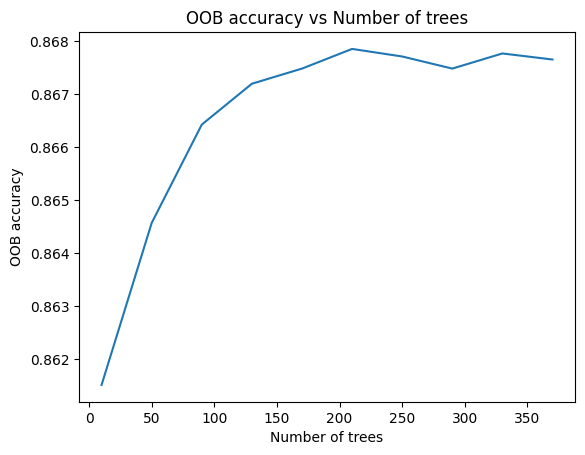

In [113]:
# tune n_estimators using OOB score
oob_accs = []

num_trees = np.arange(10,400,40)

for num_tree in num_trees:
    model = RandomForestClassifier(
        n_estimators=num_tree,
        random_state=1,
        oob_score=True
    )
    model.fit(X_train_cleaned, y_train)
    oob_accs.append(model.oob_score_)
    
plt.plot(num_trees, oob_accs)
plt.xlabel("Number of trees")
plt.ylabel("OOB accuracy")
plt.title("OOB accuracy vs Number of trees")
plt.show()

In [114]:
# highest OOB accuracy seems to be at n_estimators = 200
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    random_state=1
)

rf_class_grid = {
    'max_samples': [0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32],
    'max_features': [0.05, 0.1, 0.15],
    'bootstrap': [True, False]
}

rf_class_gscv = GridSearchCV(
    estimator=rf_classifier,
    param_grid=rf_class_grid,
    scoring=["accuracy", "recall"],
    refit="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

rf_class_gscv.fit(X_train_cleaned, y_train)
print("Best parameters: ", rf_class_gscv.best_params_)
print("Best accuracy: ", rf_class_gscv.best_score_)
best_index = rf_class_gscv.best_index_
print("Recall of best model: ", rf_class_gscv.cv_results_["mean_test_recall"][best_index])


Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters:  {'bootstrap': True, 'max_features': 0.05, 'max_samples': 0.3}
Best accuracy:  0.8830857142857143
Recall of best model:  0.14790588514898548


In [115]:
tuned_rf_class = rf_class_gscv.best_estimator_
y_pred_probs = cross_val_predict(tuned_rf_class, X_train_cleaned, y_train, cv=cv, method='predict_proba')[:, 1]

cv_results = pd.DataFrame(columns=['Threshold', 'Recall', 'Accuracy'])

thresholds = np.arange(0, 1.01, 0.01)
counter = 0

for thr in thresholds:
    cv_results.loc[counter, "Threshold"] = thr
    cv_results.loc[counter, "Recall"] = recall_score(y_train, y_pred_probs > thr)
    cv_results.loc[counter, "Accuracy"] = accuracy_score(y_train, y_pred_probs > thr)
    counter += 1

cv_results[cv_results["Accuracy"] >= 0.7]

,Threshold,Recall,Accuracy
13,0.13,0.59576,0.712457
14,0.14,0.580409,0.724429
15,0.15,0.563353,0.7382
16,0.16,0.549951,0.750429
17,0.17,0.535575,0.760629
...,...,...,...
96,0.96,0.0,0.882743
97,0.97,0.0,0.882743
98,0.98,0.0,0.882743
99,0.99,0.0,0.882743


In [116]:
high_accs = cv_results[cv_results["Accuracy"] >= 0.7]
best_recall = high_accs["Recall"].max()
best_thresh = high_accs[high_accs["Recall"] == best_recall]["Threshold"].values[0]
print(best_thresh, best_recall, high_accs[high_accs["Recall"] == best_recall]["Accuracy"])

0.13 0.5957602339181286 13    0.712457
Name: Accuracy, dtype: object


### e)

Compare the cross-validation recall of **the random forest in Part d** with the cross-validation recall of **the decision tree in Part b**. **(1 point)** What does the comparison indicate about using a number of trees together instead of a single tree? **(1 point)**

The CV recall of random forest in part d is higher than the CV recall of the decision tree in part b. This indicates that using a number of trees in random forest improves recall by reducing variance.

### f)

Find the test accuracy and test recall of the tuned random forest and the tuned threshold in Part d to see if they generalize well. **(1 point)**

In [117]:
y_test_pred_probs = tuned_rf_class.predict_proba(X_test_cleaned)[:, 1]
y_test_pred = y_test_pred_probs > best_thresh
print(recall_score(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

0.6087689713322091
0.7131676775582078


### g)

Using the tuned random forest model in Part d, print the predictor names in **decreasing order** of importance. You need to print a DataFrame with the predictor names in the first column and the importance values in the second. **(1 point)**

In [118]:
feature_imps_df = pd.DataFrame(
    tuned_rf_class.feature_importances_,
    index=X_train_cleaned.columns,
    columns=["Importance"]
).sort_values("Importance", ascending=False)

print(feature_imps_df)

                     Importance
age                    0.606691
month_may              0.025651
month_oct              0.022255
month_mar              0.021271
month_sep              0.019900
month_jul              0.019153
education_tertiary     0.017822
education_secondary    0.017497
month_aug              0.015208
month_feb              0.013307
month_jun              0.012457
month_nov              0.011460
month_dec              0.009474
education_unknown      0.009467
month_jan              0.009159
day_12                 0.008623
day_15                 0.007197
day_13                 0.007189
day_10                 0.006837
day_3                  0.006809
day_17                 0.006711
day_30                 0.006637
day_11                 0.006547
day_22                 0.006455
day_4                  0.006290
day_18                 0.006229
day_6                  0.006163
day_16                 0.006055
day_2                  0.005832
day_14                 0.005823
day_8   